# Image Classification Analysis Using Visual Geometry Group 16 (VGG16) & Mobilenet
By Group 4<br>
22073997: Olusoji Peter Sowunmi<br>
22033258: Peter Abolaji Adedeji<br>
22098853: Adeyemi Oluwasegun Abodunrin<br>
22028815: Odunola Aishat Salako<br>
22013636: Reginald Biobelemaye Charles-Granville<br>

##  About the Notebook

I imported all required libraries and loaded and preprocessed data from a specified directory in part 1,cleaned our data, and removed any problematic labels from our test data. For our image categorization, we train two models—VGG 16 and Mobilenet—for a total of 10 epochs. we investigate various models in order to determine the best VGG model for classifying images while limiting the training set to 15 epochs. We describe in detail how the optimal VGG16 model was selected.

In [ ]:
# install visualkeras to visualize the network in 3D
!pip install visualkeras

#Import all Necessary Libraries

In [ ]:
# Core TensorFlow library for machine learning and neural network models.
import tensorflow as tf
# VGG16 model from Keras applications for deep learning models pre-trained on ImageNet dataset.
from tensorflow.keras.applications import VGG16
# Utilities for preprocessing images and decoding predictions.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# OS module for operating system interactions, such as file path management.
import os
# PIL (Python Imaging Library) for image processing tasks.
import PIL
# Importing components from Keras for building and training models.
from tensorflow.keras import datasets, layers, models
# Utility to visualize the architecture of neural networks.
from keras.utils import plot_model
# Matplotlib for plotting, e.g., displaying images and graphs.
import matplotlib.pyplot as plt
# NumPy for numerical computing and handling large, multi-dimensional arrays and matrices.
import numpy as np
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [ ]:
# Import the drive module from the google.colab package.
# This allows you to access your Google Drive files directly from the notebook.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
  # read test and train data
train_data = "/content/drive/MyDrive/ads2/housing_saved_parquet/Archive (5)/seg_train/seg_train"
test_data = "/content/drive/MyDrive/ads2/housing_saved_parquet/Archive (5)/seg_test/seg_test"
image_size = (128, 128)  # Adjust this tuple according to your requirements

#Load & Processing of Data.

In [ ]:
# Function to load and preprocess data from a given directory.
def load_and_preprocess_data(directory, image_size):
    data = []  # Initialize a list to store image data
    labels = []  # Initialize a list to store image labels
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)# Get the full path to the category folder
        label = category
# Iterate through each image in the category folder
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)# Get the full path to the image
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            # Convert the image to a numpy array
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize the image data to 0-1 range
            data.append(image_array) # Append the processed image data to the data list
            labels.append(label) # Append the label to the labels list
    return np.array(data), np.array(labels)  # Convert the lists to numpy arrays for further processing in TensorFlow
# Load Train and Test data
train_images, train_labels = load_and_preprocess_data(train_data, image_size)
test_images, test_labels = load_and_preprocess_data(test_data, image_size)


#Data Shape

In [ ]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape:", train_labels.shape)

Data shape: (14119, 128, 128, 3)
Labels shape: (14119,)


#Data Cleaning

In [ ]:
label_names = unique_labels = np.unique(train_labels)
print(label_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [ ]:
# Find the label that is causing the KeyError
problematic_label = [label for label in test_labels if label not in label_names]
print("Problematic label:", problematic_label)

Problematic label: []


#Exploratory Data Analysis


In [ ]:
# Distribution of Data points among classes
freq = pd.Series(train_labels).value_counts()
print(freq)

mountain     2512
glacier      2434
street       2392
sea          2319
forest       2271
buildings    2191
dtype: int64


In [ ]:
class_to_index = {name: index for index, name in enumerate(label_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

### Verify the data

Plot the first 25 images from the training set and show the class name beneath each image to confirm that the dataset appears correct:



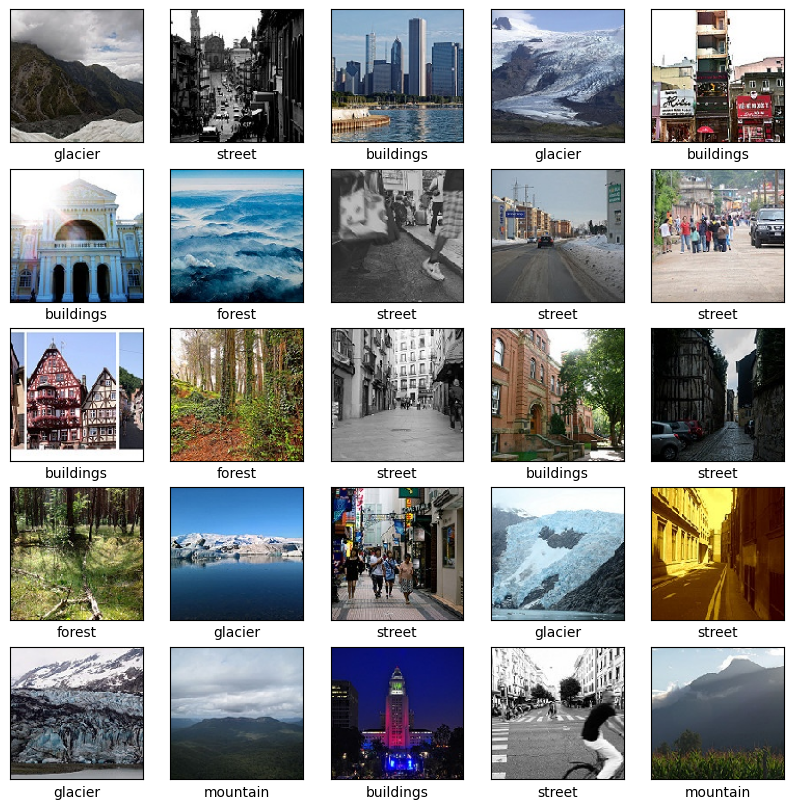

In [ ]:
label_to_index = {label: index for index, label in enumerate(label_names)}

# Select 25 random image indices
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])  # Use the random_index here
    label_index = label_to_index[train_labels[random_index]]  # And here
    plt.xlabel(label_names[label_index])
plt.show()


#Import of VGG16 model

In [ ]:
# Import the VGG16 model from TensorFlow's Keras applications module.
# A deep convolutional neural network architecture called VGG16 is well-known for its results on the ImageNet visual identification task.
from tensorflow.keras.applications import VGG16

In [ ]:
# Load the VGG16 model pre-trained weights on ImageNet dataset.
# include_top=False omits the fully connected layers at the top of the network, making it suitable for feature extraction.
# input_shape=(128, 128, 3) sets the shape of the input images the network expects. Here, it's 128x128 pixels with 3 color channels (RGB).
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [ ]:
# Iterate through each layer in the base model.
for layer in VGG_model.layers:
    # Set the layer's trainable attribute to False.
    # This action freezes the weights and biases of the layer during training, meaning they won't be updated.
    # Freezing the pre-trained layers is important in transfer learning because we want to retain the knowledge the model has already learned from the ImageNet dataset.
    layer.trainable = False

#Import Visualkeras

In [ ]:
import visualkeras

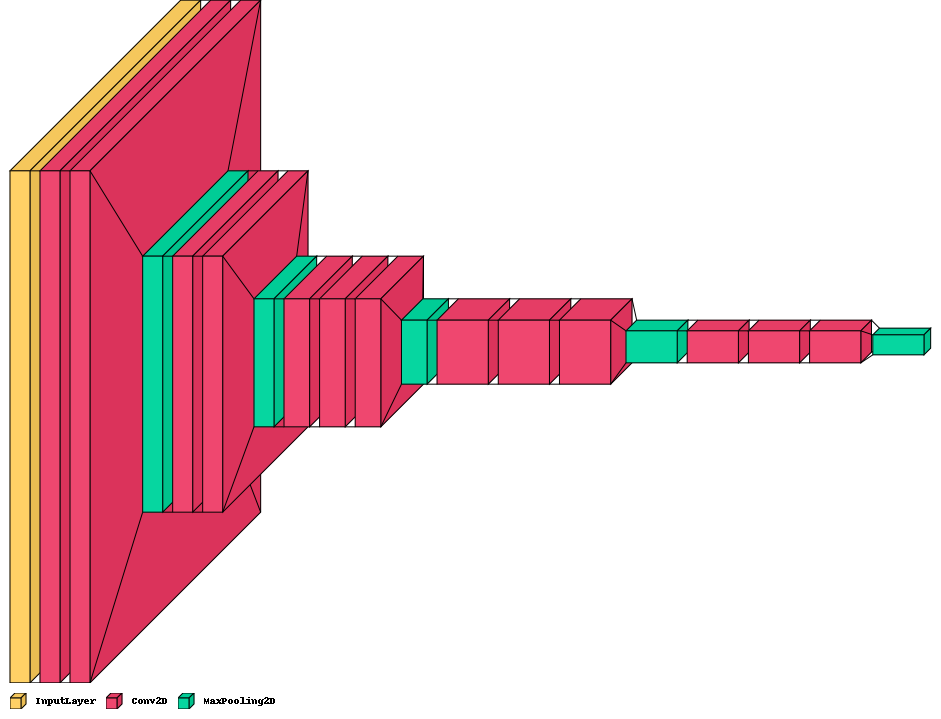

In [ ]:
# Let's visualize the model
visualkeras.layered_view(VGG_model,legend=True)

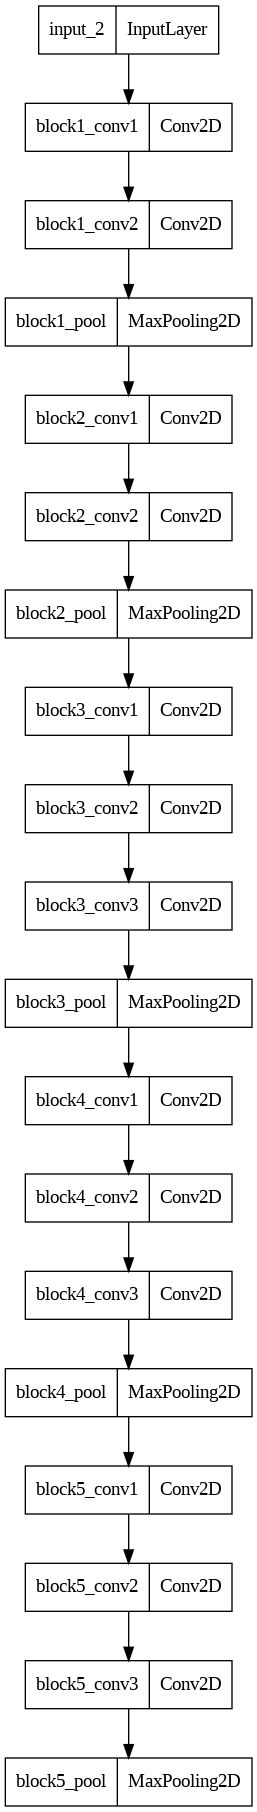

In [ ]:
plot_model(VGG_model)

#Building VGG16 Model

In [ ]:
# `num_labels` will hold the total number of labels.
num_labels = len(label_names)

In [ ]:
# Initialize a Sequential model.
Vgg16_model = models.Sequential()

# Add the pre-trained VGG16 model as the base of your model.
# This includes all the convolutional layers of VGG16, pre-trained on ImageNet.
Vgg16_model.add(VGG_model)

# Flatten the output of the VGG16 model because dense layers expect 1D inputs.
Vgg16_model.add(layers.Flatten())
Vgg16_model.add(layers.Dense(256, activation='relu')) # Add a Dense (fully connected) layer to interpret the features extracted by VGG16.
# 256 neurons are used here, but this number can be adjusted depending on your dataset's complexity.
Vgg16_model.add(layers.Dropout(0.5)) # Add a Dropout layer to prevent overfitting
# Final Dense layer for classification. The number of neurons equals the number of classes,
# with a softmax activation function to output probabilities for each class.
Vgg16_model.add(layers.Dense(num_labels, activation='softmax'))

Let's display the architecture of your model so far:

In [ ]:
Vgg16_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 16813638 (64.14 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Compile and train the VGG16model

In [ ]:
Vgg16_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

vgg16_history = Vgg16_model.fit(train_images, train_labels_encoded , epochs=10,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/10
442/442 [==============================] - 835s 2s/step - loss: 0.5720 - accuracy: 0.7876 - val_loss: 0.3819 - val_accuracy: 0.8590
Epoch 2/10
442/442 [==============================] - 815s 2s/step - loss: 0.4144 - accuracy: 0.8497 - val_loss: 0.3368 - val_accuracy: 0.8683
Epoch 3/10
442/442 [==============================] - 818s 2s/step - loss: 0.3616 - accuracy: 0.8678 - val_loss: 0.3341 - val_accuracy: 0.8767
Epoch 4/10
442/442 [==============================] - 819s 2s/step - loss: 0.3311 - accuracy: 0.8748 - val_loss: 0.3525 - val_accuracy: 0.8657
Epoch 5/10
442/442 [==============================] - 801s 2s/step - loss: 0.3166 - accuracy: 0.8826 - val_loss: 0.3345 - val_accuracy: 0.8827
Epoch 6/10
442/442 [==============================] - 791s 2s/step - loss: 0.2911 - accuracy: 0.8933 - val_loss: 0.3518 - val_accuracy: 0.8780
Epoch 7/10
442/442 [==============================] - 816s 2s/step - loss: 0.2697 - accuracy: 0.8981 - val_loss: 0.3515 - val_accuracy: 0.8727

### Evaluate the VGG16 model

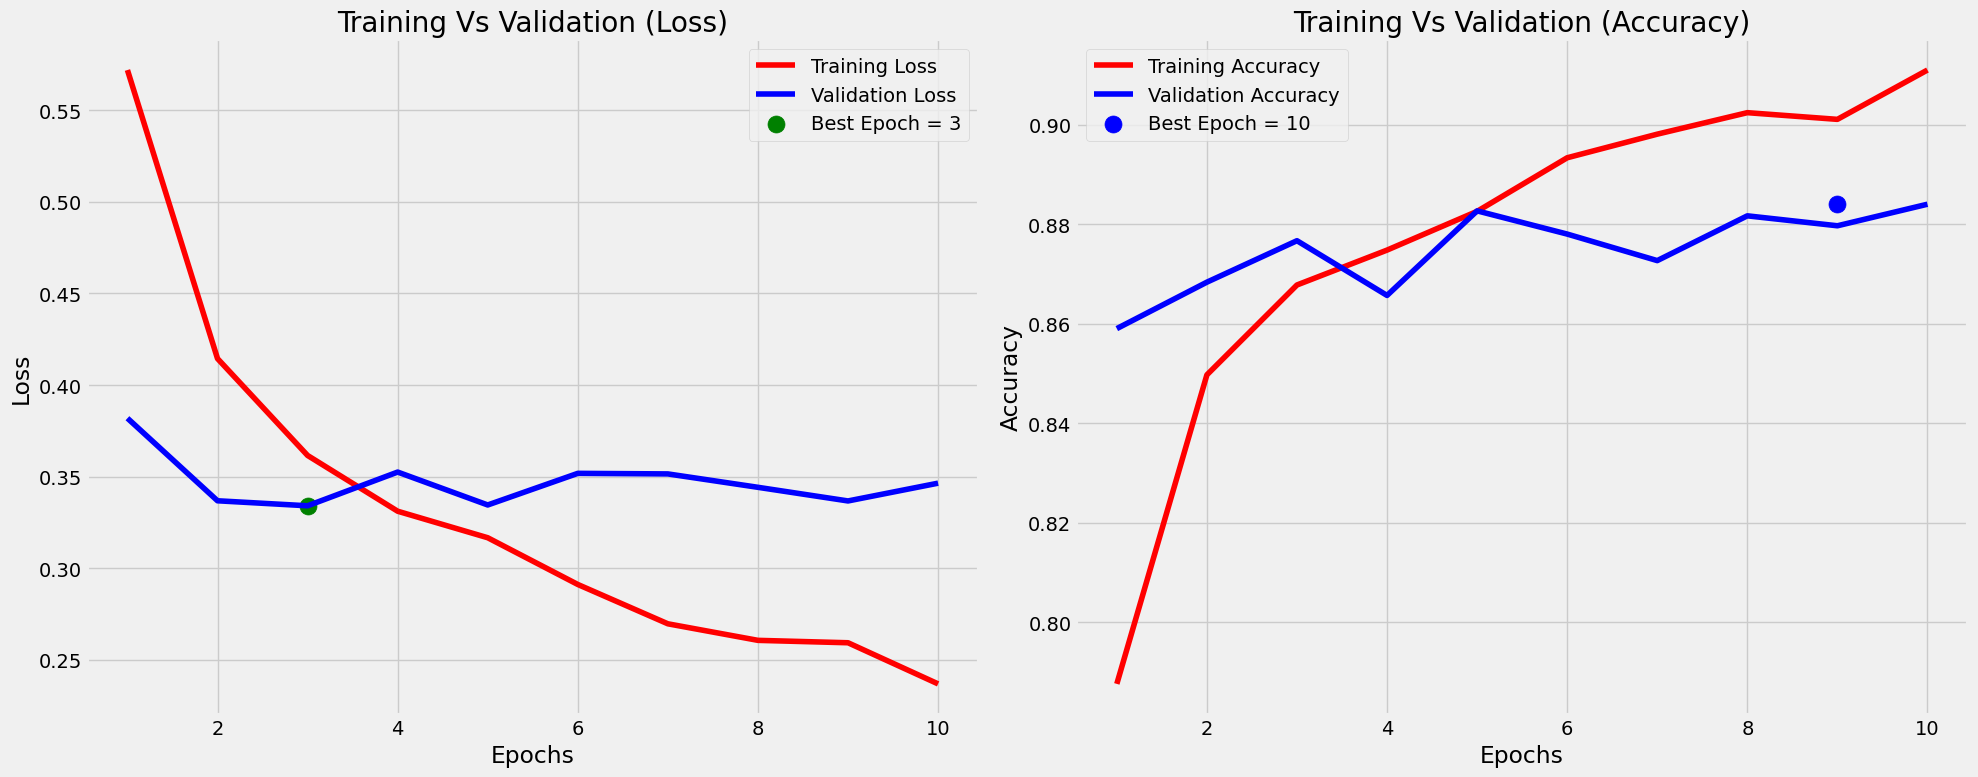

94/94 - 146s - loss: 0.3464 - accuracy: 0.8840 - 146s/epoch - 2s/step


In [ ]:
train_acc = vgg16_history.history['accuracy']
train_loss = vgg16_history.history['loss']

val_acc = vgg16_history.history['val_accuracy']
val_loss = vgg16_history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'b' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'green' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'b' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();
# Evaluate model on test data
vgg16_test_loss, vgg16_test_acc = Vgg16_model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [ ]:
print(vgg16_test_acc)

0.8840000033378601


#Building MobileNet-v2 Model

In [ ]:
 # Initialize a Sequential model.

 mobilenet_model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"),

    tf.keras.layers.Dense(num_labels, activation='softmax')
])

mobilenet_model.build([None, 128, 128, 3])  # Batch input shape.

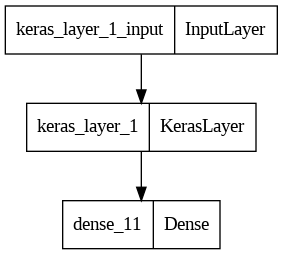

In [ ]:
plot_model(mobilenet_model)

In [ ]:
mobilenet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              1692489   
                                                                 
 dense_11 (Dense)            (None, 6)                 6012      
                                                                 
Total params: 1698501 (6.48 MB)
Trainable params: 6012 (23.48 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


### Compile and train the Mobilenet model

In [ ]:
mobilenet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
mobilenet_history = mobilenet_model.fit(train_images, train_labels_encoded , epochs=10,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/10
442/442 [==============================] - 34s 67ms/step - loss: 0.3828 - accuracy: 0.8647 - val_loss: 0.3250 - val_accuracy: 0.8897
Epoch 2/10
442/442 [==============================] - 27s 61ms/step - loss: 0.2803 - accuracy: 0.9006 - val_loss: 0.2948 - val_accuracy: 0.9027
Epoch 3/10
442/442 [==============================] - 27s 61ms/step - loss: 0.2589 - accuracy: 0.9103 - val_loss: 0.2925 - val_accuracy: 0.8970
Epoch 4/10
442/442 [==============================] - 25s 56ms/step - loss: 0.2443 - accuracy: 0.9125 - val_loss: 0.2941 - val_accuracy: 0.8950
Epoch 5/10
442/442 [==============================] - 24s 53ms/step - loss: 0.2352 - accuracy: 0.9151 - val_loss: 0.3208 - val_accuracy: 0.8980
Epoch 6/10
442/442 [==============================] - 23s 53ms/step - loss: 0.2269 - accuracy: 0.9183 - val_loss: 0.3451 - val_accuracy: 0.8857
Epoch 7/10
442/442 [==============================] - 24s 53ms/step - loss: 0.2206 - accuracy: 0.9182 - val_loss: 0.2910 - val_accuracy:

### Evaluate the MobileNet model

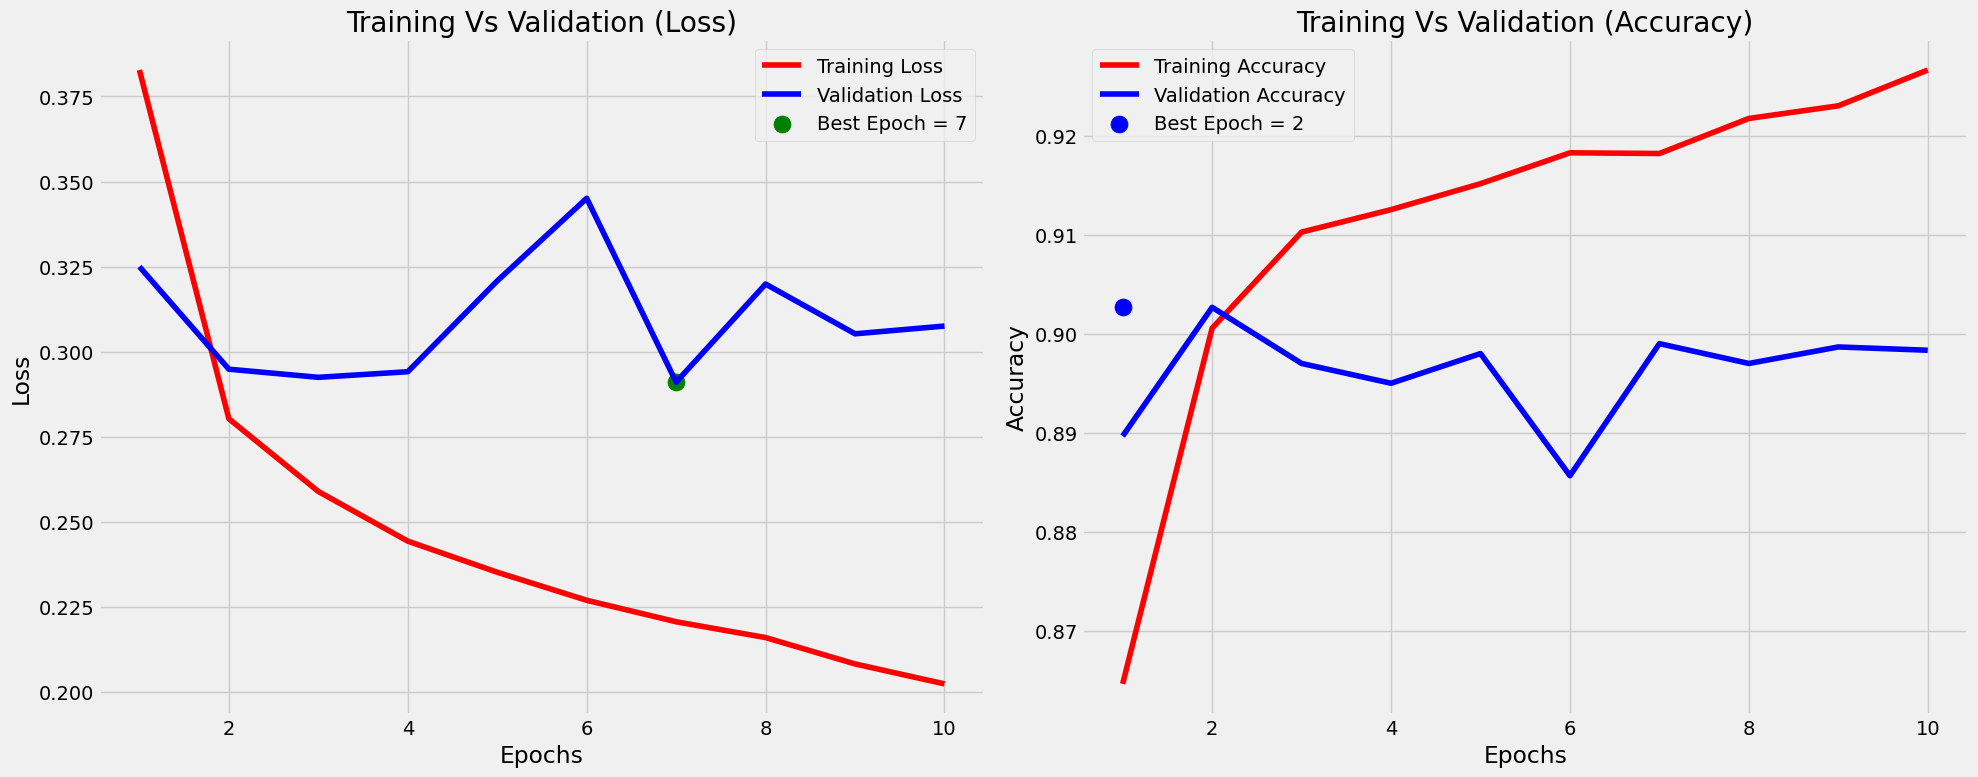

94/94 - 5s - loss: 0.3075 - accuracy: 0.8983 - 5s/epoch - 50ms/step


In [ ]:
train_acc = mobilenet_history.history['accuracy']
train_loss = mobilenet_history.history['loss']

val_acc = mobilenet_history.history['val_accuracy']
val_loss = mobilenet_history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'b' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'green' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'b' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

# Evaluate model on test data
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(test_images,  test_labels_encoded, verbose=2)


In [ ]:
print(mobilenet_test_acc)

0.8983333110809326


#Built Model From Scratch

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32 , kernel_size=(5,5),
                           strides=(1,1), padding="same", activation="relu",
                           input_shape=train_images[0].shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64 , kernel_size=(5,5),activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)       

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_images, train_labels_encoded , epochs=10,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/10
442/442 [==============================] - 228s 512ms/step - loss: 1.5311 - accuracy: 0.6127 - val_loss: 1.1174 - val_accuracy: 0.5867
Epoch 2/10
442/442 [==============================] - 229s 518ms/step - loss: 0.7108 - accuracy: 0.7416 - val_loss: 0.8620 - val_accuracy: 0.7103
Epoch 3/10
442/442 [==============================] - 232s 524ms/step - loss: 0.5551 - accuracy: 0.8009 - val_loss: 1.8699 - val_accuracy: 0.4820
Epoch 4/10
442/442 [==============================] - 220s 498ms/step - loss: 0.4318 - accuracy: 0.8435 - val_loss: 0.7745 - val_accuracy: 0.7273
Epoch 5/10
442/442 [==============================] - 218s 493ms/step - loss: 0.3339 - accuracy: 0.8785 - val_loss: 0.7577 - val_accuracy: 0.7510
Epoch 6/10
442/442 [==============================] - 218s 492ms/step - loss: 0.2701 - accuracy: 0.9021 - val_loss: 0.6928 - val_accuracy: 0.7867
Epoch 7/10
442/442 [==============================] - 217s 492ms/step - loss: 0.2262 - accuracy: 0.9207 - val_loss: 1.3721 -

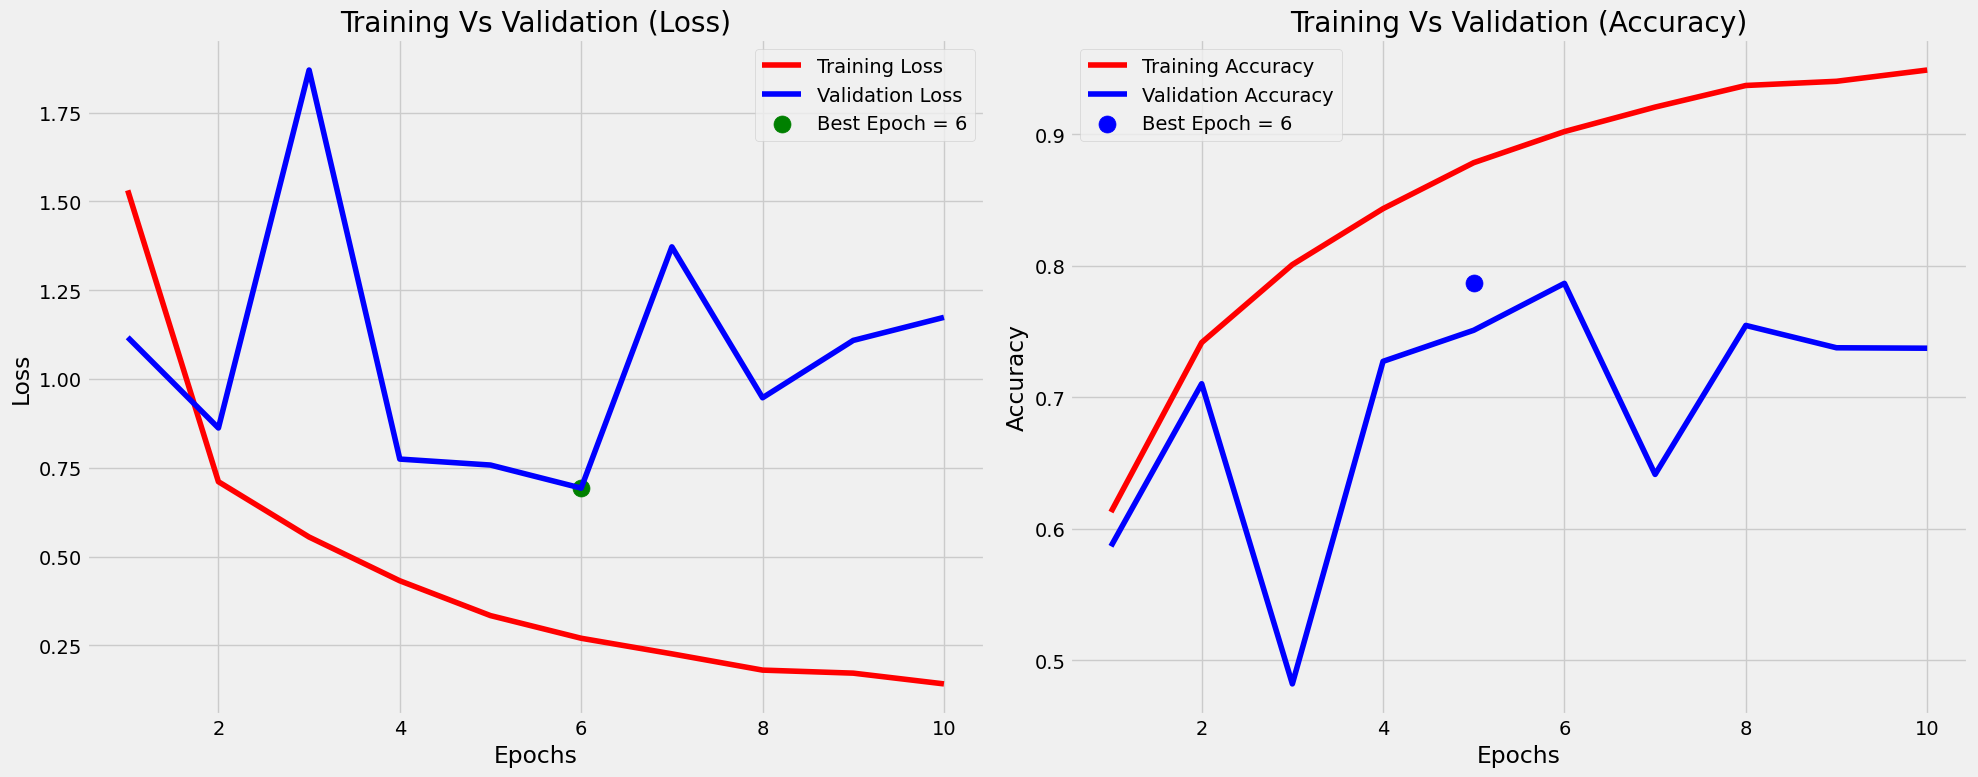

94/94 - 14s - loss: 1.1736 - accuracy: 0.7373 - 14s/epoch - 151ms/step


In [ ]:
train_acc = model_history.history['accuracy']
train_loss = model_history.history['loss']

val_acc = model_history.history['val_accuracy']
val_loss = model_history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'b' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'green' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'b' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();


# Evaluate model on test data
model_test_loss, model_test_acc = model.evaluate(test_images,  test_labels_encoded, verbose=2)


In [ ]:
model_test_acc

0.737333357334137

##Check for predictions for validation images using the best model which is VGG16

94/94 [==============================] - 138s 1s/step


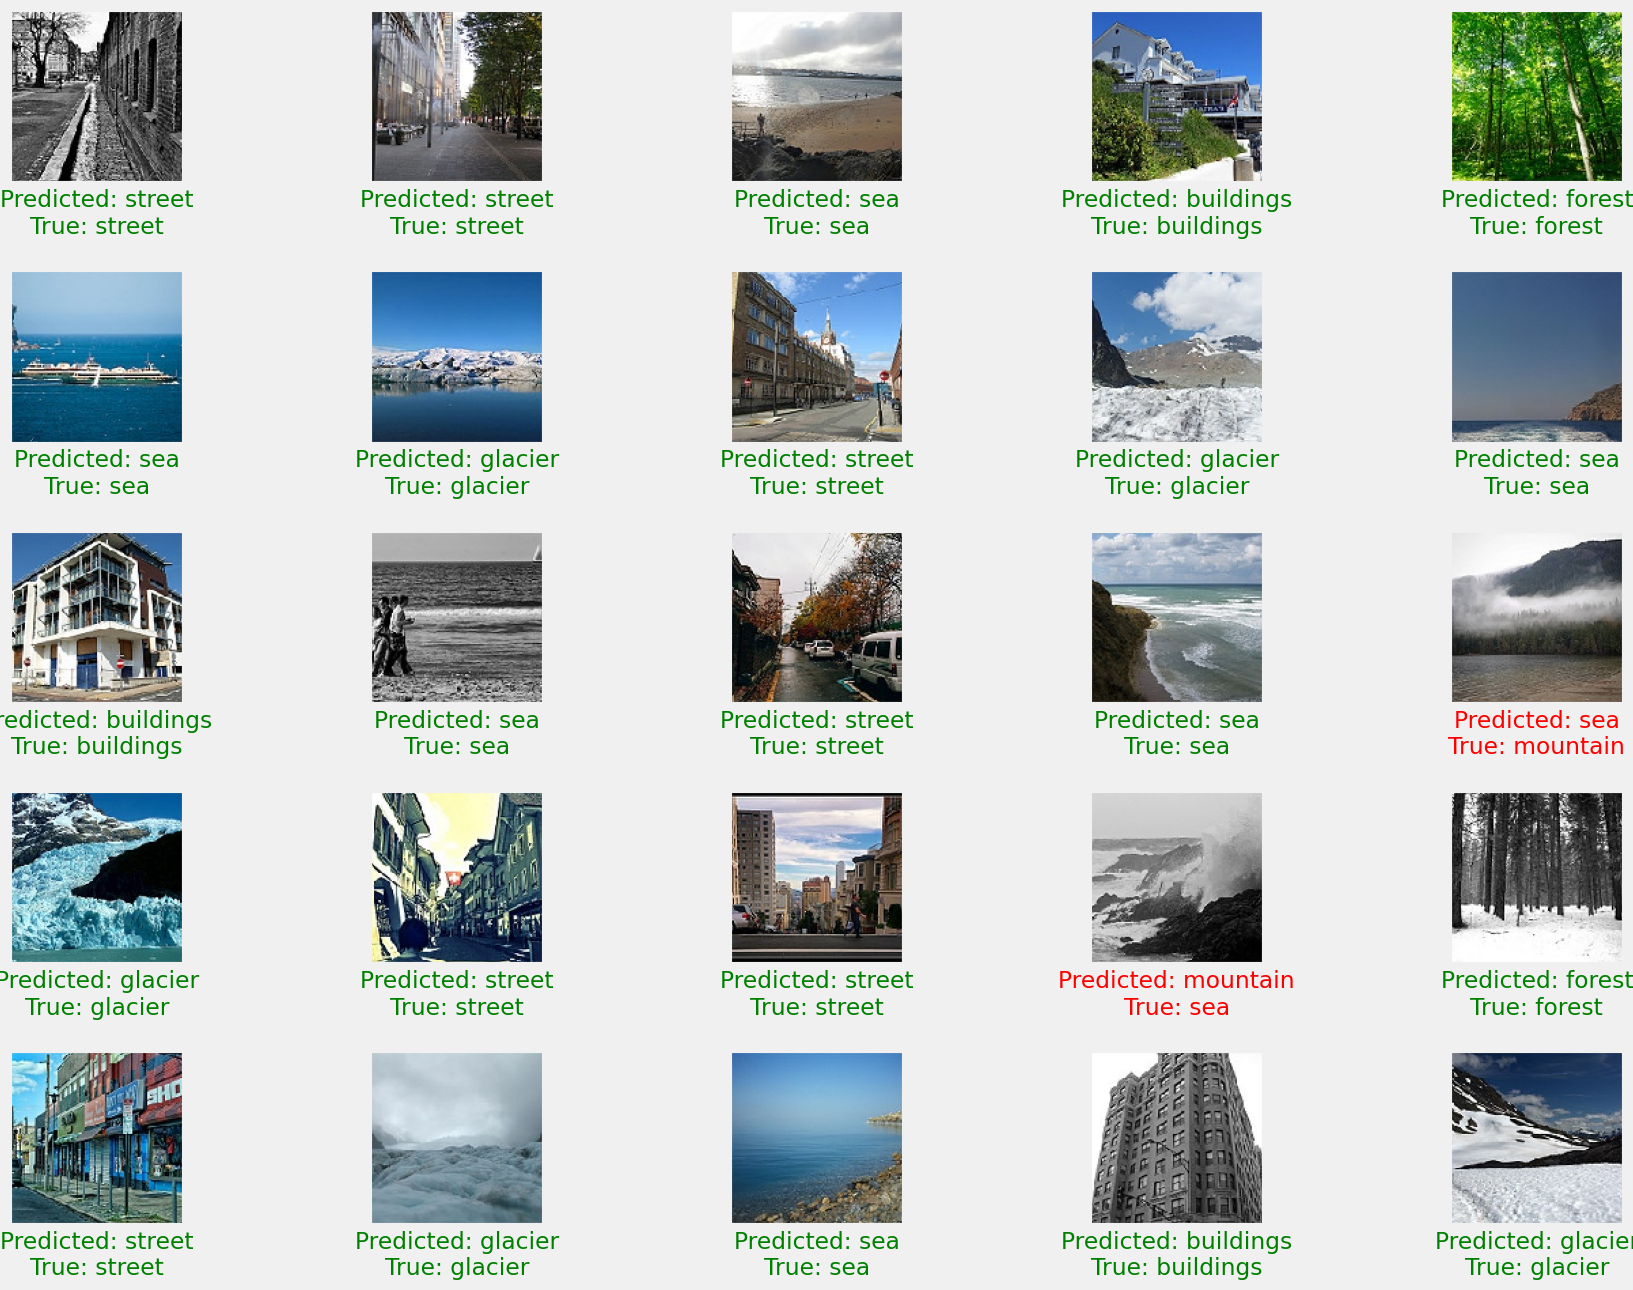

In [ ]:
# First, get predictions for validation images
predicted_scores = Vgg16_model.predict(test_images)
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = {index: label for label, index in class_to_index.items()}

# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(test_images), size=25, replace=False)

plt.figure(figsize=(20, 15))  # Adjust figure size for better visibility
plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
for idx, random_index in enumerate(random_indices):
    plt.subplot(5, 5, idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    true_label = test_labels[random_index]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"Predicted: {predicted_label}\nTrue: {true_label}", color=color)  # Plotting predicted label (true


In [ ]:
test_labels

array(['mountain', 'mountain', 'mountain', ..., 'sea', 'sea', 'sea'],
      dtype='<U9')

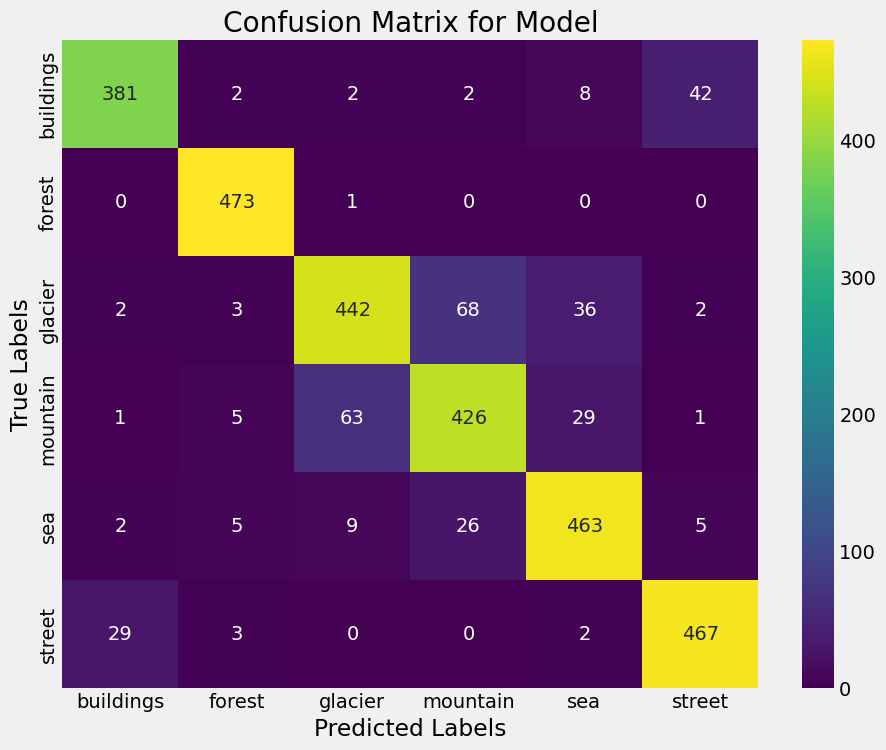

In [ ]:
# Ensure that test_labels_filtered are encoded
test_labels_encoded_filtered = np.array([class_to_index[label] for label in test_labels])

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded_filtered, predicted_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_class[i] for i in range(len(index_to_class))],
            yticklabels=[index_to_class[i] for i in range(len(index_to_class))])
plt.title('Confusion Matrix for Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Conclusion
Based on the test accuracy values of the models on test data, we decided to explore and use VGG16 model. VGG16 is the best model for our image classification with training restricted for 10 epochs.